In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.cuda.is_available()

True

### 데이터 전처리

In [3]:
data=pd.read_csv('../chap07/data/AirPassengers.csv')

# 날짜 데이터를 연도와 월로 분리하여 새로운 열로 추가
# data['Year'] = data['Month'].apply(lambda x: int(x.split('-')[0]))
# data['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))

# #데이터 타입을 float로 설정
data['#Passengers'] = data['#Passengers'].astype(float)
data['Month'] = pd.to_datetime(data['Month'])
# data['Year'] = data['Year'].astype(float)

# # 컬럼 순서 변경
# data = data[['Year', 'Month', '#Passengers']]

# # 컬럼명 변경
# data.columns = ['Year', 'Month', '#Passengers']


print(data.dtypes)
print(data)



Month          datetime64[ns]
#Passengers           float64
dtype: object
         Month  #Passengers
0   1949-01-01        112.0
1   1949-02-01        118.0
2   1949-03-01        132.0
3   1949-04-01        129.0
4   1949-05-01        121.0
..         ...          ...
139 1960-08-01        606.0
140 1960-09-01        508.0
141 1960-10-01        461.0
142 1960-11-01        390.0
143 1960-12-01        432.0

[144 rows x 2 columns]


>데이터 스케일조정


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MinMaxScaler 객체 생성
ms = MinMaxScaler()
ss = StandardScaler()

# 스케일링할 열 선택 (연도와 월 제외)
columx = ['#Passengers']
columy = ['Month']

# 데이터 스케일링
data[columx] = ms.fit_transform(data[columx])
data[columy] = ss.fit_transform(data[columy])



##데이터의 스케일이[0,1] 범위 내로 조정

# 스케일링된 데이터 확인
print(data.head())
print(data.tail())

#결측지 확인
print(data.isnull().sum())


      Month  #Passengers
0 -1.719216     0.015444
1 -1.694715     0.027027
2 -1.672584     0.054054
3 -1.648083     0.048263
4 -1.624372     0.032819
        Month  #Passengers
139  1.624043     0.969112
140  1.648544     0.779923
141  1.672255     0.689189
142  1.696756     0.552124
143  1.720467     0.633205
Month          0
#Passengers    0
dtype: int64


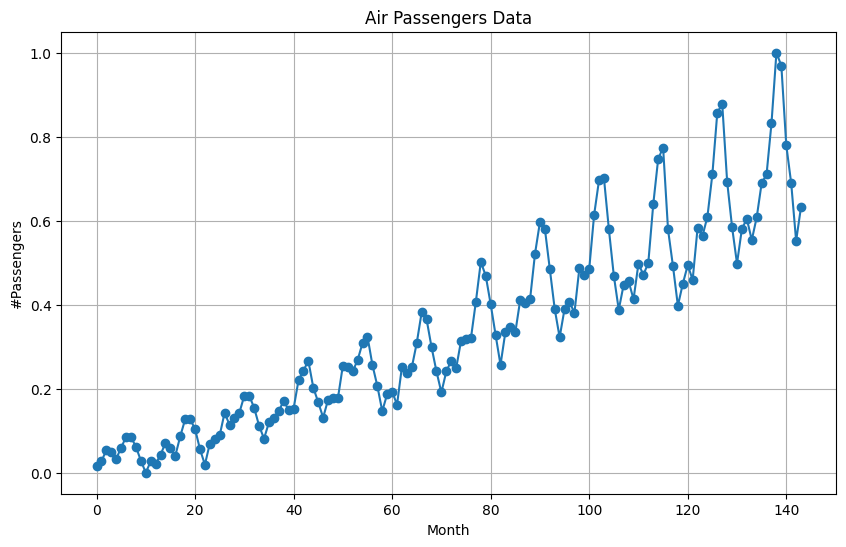

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['#Passengers'], marker='o')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.title('Air Passengers Data')
plt.grid(True)
plt.show()



In [6]:
df = pd.DataFrame(data)
print(df)

        Month  #Passengers
0   -1.719216     0.015444
1   -1.694715     0.027027
2   -1.672584     0.054054
3   -1.648083     0.048263
4   -1.624372     0.032819
..        ...          ...
139  1.624043     0.969112
140  1.648544     0.779923
141  1.672255     0.689189
142  1.696756     0.552124
143  1.720467     0.633205

[144 rows x 2 columns]


### 시계열 분해

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

> STL 분해 모델은 가법적(Additive) 또는 곱셈적(Multiplicative) 계절성을 사용할 수 있습니다.

가법적 계절성은 계절성 요소가 시간이 지남에 따라 일정한 크기로 증가 또는 감소하는 경우에 적합하며, 곱셈적 계절성은 계절성 요소가 시간이 지남에 따라 상대적으로 크기가 변하는 경우에 적합합니다. 데이터에 0 또는 음수 값이 있는 경우 곱셈적 계절성을 사용하는 것은 적절하지 않을 수 있습니다.

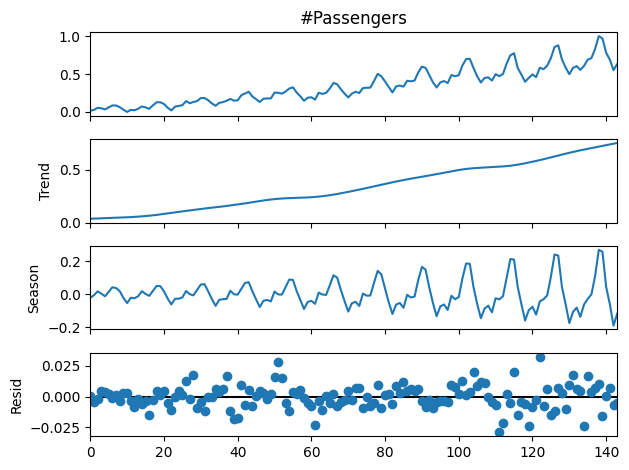

In [8]:
stl = STL(df['#Passengers'], period=12)  # seasonal 주기를 12로 설정 (연 단위)
result = stl.fit()
# 시각화
result.plot()
plt.show()

In [74]:
# 데이터 인덱스에 시계열 분해 데이터 넣기
df['Resid'] = result.resid
df['seasonal'] = result.seasonal
df['trend']= result.trend
df['difference'] = df['#Passengers'].diff()
df['difference2'] = df['#Passengers'].diff(2)

# 널값 제거
df = df.dropna(subset=['difference'])
df = df.dropna(subset=['difference2'])
print(df)
print(df.isnull().sum())

        Month  #Passengers     Resid  seasonal     trend  difference  \
6   -1.576159     0.084942 -0.001548  0.042183  0.044307    0.025097   
7   -1.551658     0.084942  0.001556  0.037633  0.045753    0.000000   
8   -1.527157     0.061776 -0.003673  0.018225  0.047225   -0.023166   
9   -1.503445     0.028958  0.002588 -0.022348  0.048718   -0.032819   
10  -1.478944     0.000000  0.003183 -0.053404  0.050221   -0.028958   
..        ...          ...       ...       ...       ...         ...   
139  1.624043     0.969112 -0.016076  0.256683  0.728505   -0.030888   
140  1.648544     0.779923  0.000316  0.044194  0.735412   -0.189189   
141  1.672255     0.689189  0.006831 -0.059914  0.742273   -0.090734   
142  1.696756     0.552124 -0.007235 -0.189729  0.749088   -0.137066   
143  1.720467     0.633205 -0.005018 -0.117636  0.755858    0.081081   

     difference2  
6       0.052124  
7       0.025097  
8      -0.023166  
9      -0.055985  
10     -0.061776  
..           ...  
13

### 데이터 분할

In [75]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 데이터 분할
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# 시계열 데이터로 변환
def create_sequences(df, seq_length):
    sequences = []
    for i in range(len(df) - seq_length):
        sequence = df[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# 시퀀스 길이 설정
seq_length = 1  # 임의의 값으로 설정

# 입력 및 출력 생성
X_train = create_sequences(train_data[['Resid','Month','seasonal','trend','#Passengers','difference','difference2']], seq_length)
X_test = create_sequences(test_data[['Resid','Month','seasonal','trend','#Passengers','difference','difference2']], seq_length)
y_train = train_data['#Passengers'].values[seq_length:]
y_test = test_data['#Passengers'].values[seq_length:]
x_df= create_sequences(df[['Resid','Month','seasonal','trend','#Passengers','difference','difference2']],seq_length)
y_df= df['#Passengers'].values[seq_length:]

print(x_df.shape)
print(X_train.shape)



(137, 1, 7)
(109, 1, 7)


>모델 학습 전 텐서형식으로 변경

In [76]:
# PyTorch Tensor로 변환
X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)
x_df= torch.tensor(x_df,dtype=torch.float32)
y_df= torch.tensor(y_df,dtype=torch.float32)
# 데이터 shape 조정 (batch_size, seq_length, feature_size)
X_train_tensors = X_train_tensors.view(X_train_tensors.shape[0], X_train_tensors.shape[1], -1)
X_test_tensors = X_test_tensors.view(X_test_tensors.shape[0], X_test_tensors.shape[1], -1)
y_train_tensors = y_train_tensors.view(y_train_tensors.shape[0], 1)
y_test_tensors = y_test_tensors.view(y_test_tensors.shape[0], 1)
x_df_tensors = x_df.view(x_df.shape[0],x_df.shape[1], -1)
y_df_tensors = y_df.view(y_df.shape[0],1)

# 텐서 데이터셋 생성
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
df_dataset=TensorDataset(x_df_tensors,y_df_tensors)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
df_loader= DataLoader(dataset= df_dataset, batch_size=batch_size, shuffle=False)


print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape)
print("df Shape",x_df_tensors.shape, y_df_tensors.shape)


Training Shape torch.Size([109, 1, 7]) torch.Size([109, 1])
Testing Shape torch.Size([27, 1, 7]) torch.Size([27, 1])
df Shape torch.Size([137, 1, 7]) torch.Size([137, 1])


### LSTM 모델

>모델 정의 및 설정

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 하이퍼파라미터 설정
input_size = X_train_tensors.shape[2]  # 입력 차원
hidden_size = 128  # 은닉 상태 차원
num_layers = 2  # LSTM 층의 수
output_size = 1  # 출력 차원
num_epochs = 60  # 에포크 수
learning_rate = 0.001  # 학습률

>모델 훈련

In [85]:
# LSTM 모델 초기화
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(X_train_tensors.device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()  # 손실 함수: 평균 제곱 오차
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # 옵티마이저: Adam
# 모델 학습
for epoch in range(num_epochs):
    model.train()  # 학습 모드로 설정
    optimizer.zero_grad()  # 기울기 초기화
    
    # 순전파 및 손실 계산
    outputs = model(X_train_tensors)
    loss = criterion(outputs, y_train_tensors)
    
    # 역전파 및 가중치 업데이트
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 모델 예측
model.eval()  # 평가 모드로 설정
with torch.no_grad():
    test_outputs = model(x_df_tensors)

# 텐서를 numpy 배열로 변환
predicted = test_outputs.cpu().detach().numpy()

# 실제 레이블을 numpy 배열로 변환
label_y = y_df_tensors.cpu().detach().numpy()

# 예측 값과 실제 값 비교
print(predicted)


Epoch [10/60], Loss: 0.0931
Epoch [20/60], Loss: 0.0386
Epoch [30/60], Loss: 0.0104
Epoch [40/60], Loss: 0.0071
Epoch [50/60], Loss: 0.0032
Epoch [60/60], Loss: 0.0026
[[0.02007825]
 [0.01837416]
 [0.0111999 ]
 [0.00414715]
 [0.00205976]
 [0.021712  ]
 [0.02332591]
 [0.03255311]
 [0.04576948]
 [0.03950876]
 [0.03457569]
 [0.05868755]
 [0.07525763]
 [0.07001282]
 [0.05967928]
 [0.04683188]
 [0.04336138]
 [0.07486758]
 [0.0803384 ]
 [0.08203091]
 [0.1055446 ]
 [0.09076004]
 [0.09769413]
 [0.10980445]
 [0.1279333 ]
 [0.12628165]
 [0.11182652]
 [0.10027145]
 [0.09796277]
 [0.12692855]
 [0.13379322]
 [0.1391679 ]
 [0.15377392]
 [0.14249977]
 [0.14788261]
 [0.18359888]
 [0.1913074 ]
 [0.19430774]
 [0.16317782]
 [0.1550503 ]
 [0.15295914]
 [0.18567657]
 [0.19108962]
 [0.18917319]
 [0.22968557]
 [0.22142547]
 [0.21173227]
 [0.23369366]
 [0.25765687]
 [0.25953197]
 [0.22205067]
 [0.20785883]
 [0.1980787 ]
 [0.23715231]
 [0.24701434]
 [0.23118168]
 [0.28431177]
 [0.27251723]
 [0.2728992 ]
 [0.30

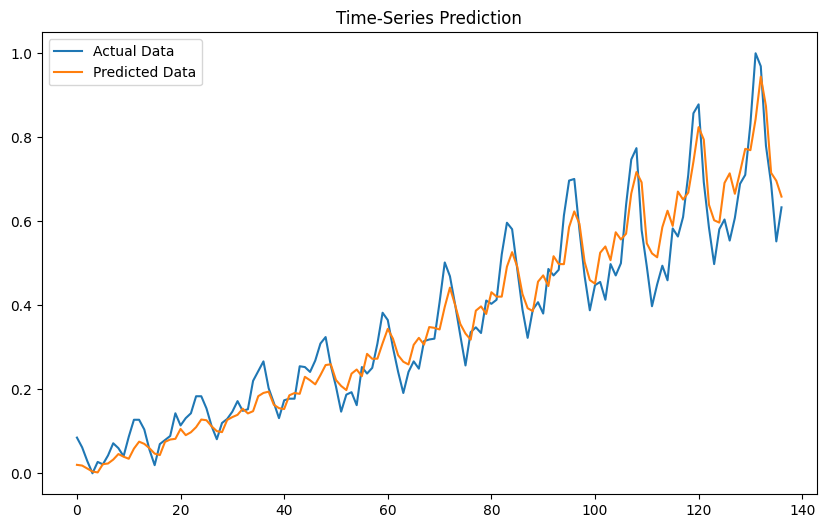

In [86]:
# 예측된 데이터와 실제 데이터를 포함한 전체 데이터셋 생성
all_data = np.concatenate((label_y.reshape(-1, 1), predicted.reshape(-1, 1)), axis=1)

# 전체 데이터셋 시각화
plt.figure(figsize=(10, 6))
plt.plot(all_data[:, 0], label='Actual Data')
plt.plot(all_data[:, 1], label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## 20240522 윈도우셋

In [70]:
label = data['#Passengers'].shift(-1)
label

## 데이터를 하나씩 옮겨서 정답지

0      0.027027
1      0.054054
2      0.048263
3      0.032819
4      0.059846
         ...   
139    0.779923
140    0.689189
141    0.552124
142    0.633205
143         NaN
Name: #Passengers, Length: 144, dtype: float64

In [7]:
def make_dataset(data, label, window_size=4):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size-1]))
    return np.array(feature_list), np.array(label_list)

data

,Month,#Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


In [8]:
X,y = make_dataset(data['#Passengers'],label)

print(X)
print(y)


[[112. 118. 132. 129.]
 [118. 132. 129. 121.]
 [132. 129. 121. 135.]
 [129. 121. 135. 148.]
 [121. 135. 148. 148.]
 [135. 148. 148. 136.]
 [148. 148. 136. 119.]
 [148. 136. 119. 104.]
 [136. 119. 104. 118.]
 [119. 104. 118. 115.]
 [104. 118. 115. 126.]
 [118. 115. 126. 141.]
 [115. 126. 141. 135.]
 [126. 141. 135. 125.]
 [141. 135. 125. 149.]
 [135. 125. 149. 170.]
 [125. 149. 170. 170.]
 [149. 170. 170. 158.]
 [170. 170. 158. 133.]
 [170. 158. 133. 114.]
 [158. 133. 114. 140.]
 [133. 114. 140. 145.]
 [114. 140. 145. 150.]
 [140. 145. 150. 178.]
 [145. 150. 178. 163.]
 [150. 178. 163. 172.]
 [178. 163. 172. 178.]
 [163. 172. 178. 199.]
 [172. 178. 199. 199.]
 [178. 199. 199. 184.]
 [199. 199. 184. 162.]
 [199. 184. 162. 146.]
 [184. 162. 146. 166.]
 [162. 146. 166. 171.]
 [146. 166. 171. 180.]
 [166. 171. 180. 193.]
 [171. 180. 193. 181.]
 [180. 193. 181. 183.]
 [193. 181. 183. 218.]
 [181. 183. 218. 230.]
 [183. 218. 230. 242.]
 [218. 230. 242. 209.]
 [230. 242. 209. 191.]
 [242. 209.

In [9]:
print(len(X))
print(len(y))
#두개의 길이가 같아야함


140
140


>>트레이닝이랑 테스트 분리

In [10]:
X_train = X[:100, :]
X_test = X[100:, :]

y_train = y[:100]
y_test = y[100:]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (100, 4) (100,)
Testing Shape (40, 4) (40,)


In [24]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 텐서로 변환
X_train_tensors = Variable(torch.Tensor(X_train_scaled))
X_test_tensors = Variable(torch.Tensor(X_test_scaled))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# 데이터 shape 조정
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
y_train_tensors = torch.reshape(y_train_tensors, (y_train_tensors.shape[0], 1))
y_test_tensors = torch.reshape(y_test_tensors, (y_test_tensors.shape[0], 1))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)


Training Shape torch.Size([100, 1, 4]) torch.Size([100, 1])
Testing Shape torch.Size([40, 1, 4]) torch.Size([40, 1])


### 하던

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [ ]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 4
hidden_size = 2 
num_layers = 100

num_classes = 1 
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors) 
    loss.backward() 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

## 원래 있던거

>데이터셋 및 데이터 로더 생성

In [25]:

# 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensors_f, y_train_tensors)
test_dataset = TensorDataset(X_test_tensors_f, y_test_tensors)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


## LSTM 모델 및 학습


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [42]:
# 모델, 손실 함수 및 옵티마이저 설정
input_size = X_train_tensors_f.shape[2]
hidden_size = 4
num_layers = 2
num_classes = 1 
num_epochs = 1000
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(X_train_tensors_f.device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 및 테스트 손실 저장 리스트
train_losses = []
test_losses = []

# 모델 학습
model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(X_train_tensors_f.device), targets.to(y_train_tensors.device)
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()

        
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # 평균 훈련 손실 저장
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # 100 에포크마다 훈련 손실 출력
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_train_loss:.4f}")

    # 모델 평가
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(X_train_tensors_f.device), targets.to(y_test_tensors.device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            epoch_test_loss += loss.item()

    train_predict = model(X_test_tensors_f)
    
    
    # 평균 테스트 손실 저장
    epoch_test_loss /= len(test_loader)
    test_losses.append(epoch_test_loss)

    model.train()  # 평가 후 모델을 다시 학습 모드로 전환

    

# 최종 테스트 손실 출력
print(f"Final Test Loss: {test_losses[-1]:.4f}")

Epoch [0/5000], Loss: 59677.9150
Epoch [100/5000], Loss: 43203.7810
Epoch [200/5000], Loss: 30790.4491
Epoch [300/5000], Loss: 21392.5988
Epoch [400/5000], Loss: 14821.2174
Epoch [500/5000], Loss: 10717.7378
Epoch [600/5000], Loss: 8499.7502
Epoch [700/5000], Loss: 7465.5106
Epoch [800/5000], Loss: 7034.6931
Epoch [900/5000], Loss: 6866.7191
Epoch [1000/5000], Loss: 6803.4509
Epoch [1100/5000], Loss: 6780.1373
Epoch [1200/5000], Loss: 6771.7322
Epoch [1300/5000], Loss: 6768.8034
Epoch [1400/5000], Loss: 6767.8436
Epoch [1500/5000], Loss: 6767.5662
Epoch [1600/5000], Loss: 6767.5161


KeyboardInterrupt: 

In [36]:
print(outputs)

tensor([[224.4053]])


tensor([[224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053],
        [224.4053]], grad_fn=<AddmmBackward0>)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

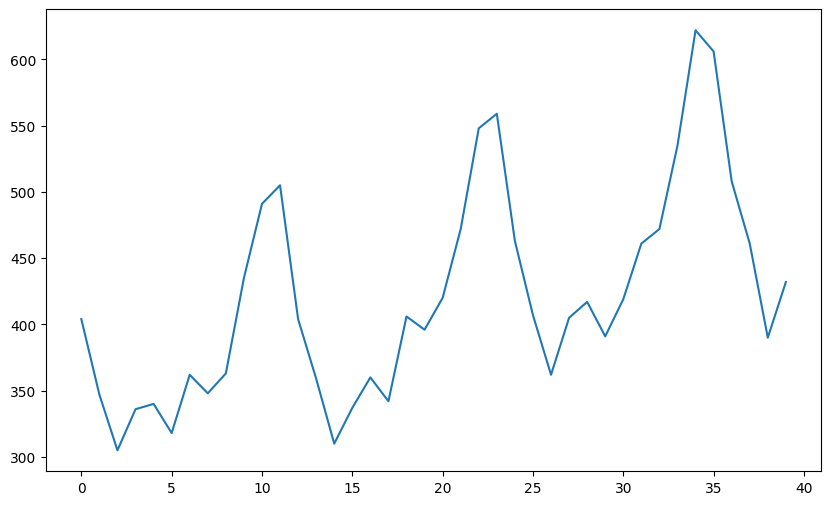

In [40]:
predicted = train_predict.data.numpy()
print(predicted)
label_y = y_test_tensors.data.numpy()

plt.figure(figsize=(10,6)) 


plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

## LsTM모델 수정중에 주석 
 

In [ ]:

# class LSTM(nn.Module):
#     def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
#         super(LSTM, self).__init__()
#         self.num_classes = num_classes 
#         self.num_layers = num_layers 
#         self.input_size = input_size 
#         self.hidden_size = hidden_size 
#         self.seq_length = seq_length 

#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                           num_layers=num_layers, batch_first=True) 
#         self.fc_1 =  nn.Linear(hidden_size, 128) 
#         self.fc = nn.Linear(128, num_classes) 

#         self.relu = nn.ReLU()
    
#     def forward(self,x):
#         h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
#         c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
#         output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
#         hn = hn.view(-1, self.hidden_size) 
#         out = self.relu(hn)
#         out = self.fc_1(out) 
#         out = self.relu(out) 
#         out = self.fc(out)
#         return out


>>분류는 문제는 정확도, 회귀 문제는 mse,rmse 오차확인

In [ ]:
# num_epochs = 30000 
# learning_rate = 0.01

# input_size = 12 
# hidden_size = 2 
# num_layers = 1 

# num_classes = 1 
# model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 


In [ ]:
targets.view(-1, 1)

In [ ]:
# for epoch in range(num_epochs):
#     outputs = model.forward(X_train_tensors_f) 
#     optimizer.zero_grad()  
#     loss = criterion(outputs, y_train_tensors) 
#     loss.backward() 
#     optimizer.step() 
#     if epoch % 100 == 0:
#         print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 